In [ ]:
# Objectif : Importer les bibliothèques nécessaires à l’analyse exploratoire.
# Pourquoi ? Pandas permet la manipulation des données, NumPy le calcul numérique, et Matplotlib/Seaborn la visualisation.
# Résultat : L’environnement est prêt pour charger et analyser les données.


# 1/ Préparation de l’environnement

import warnings
warnings.filterwarnings("ignore")

# Imports des librairies nécessaires avant modélisation


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

In [ ]:
# 2/ Chargement des données brutes

# Objectif : Charger les fichiers bruts (SIRH, Evaluation, Survey) et examiner leur structure.
# Pourquoi ? Comprendre la dimension, les colonnes et les types de données avant toute transformation.
# Résultat : Les trois fichiers contiennent chacun 1470 lignes, ce qui permet un merge cohérent.

df = pd.read_csv("../data/df_clean.csv")
print(df.shape)
df.head()

(1470, 32)


,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,...,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,has_left
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,...,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,...,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,0
2,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,...,1,4,2,2,Autre,Y,Occasionnel,0,0,1
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,...,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,0
4,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,...,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,0


In [ ]:
# 3/ Chargement des données brutes

# Objectif : Uniformiser les noms de colonnes (minuscules, suppression des espaces).
# Pourquoi ? Éviter les erreurs lors des merges et garantir une cohérence dans le code.
# Résultat : Les noms de colonnes sont propres et standardisés.

df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

In [ ]:
# 4/ Nettoyage des colonnes

# Objectif : Fusionner les trois datasets en un seul DataFrame central.
# Pourquoi ? La modélisation nécessite un dataset unique regroupant toutes les variables explicatives et la cible.
# Résultat : Le DataFrame final contient 1470 lignes et 34 colonnes.

df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")

In [ ]:
# 5/ Création du DataFrame central

# Objectif : Fusionner les trois datasets en un seul DataFrame central.
# Pourquoi ? La modélisation nécessite un dataset unique regroupant toutes les variables explicatives et la cible.
# Résultat : Le DataFrame final contient 1470 lignes et 34 colonnes.

y = df["has_left"]
X = df.drop("has_left", axis=1)

In [ ]:
# 6/ Identification des variables pertinentes

# Objectif : Identifier les variables numériques et catégorielles du dataset.
# Pourquoi ? Séparer les types de variables est essentiel pour appliquer les bons traitements (scaling pour les numériques, encodage pour les catégorielles).
# Résultat : Les variables numériques et catégorielles sont listées, ce qui permettra de construire des pipelines adaptés pour la modélisation.

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numériques :", num_features)
print("Catégorielles :", cat_features)

Numériques : ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']
Catégorielles : ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


In [ ]:
# 7/ Stratification des données

# Objectif : Séparer les données en jeu d'entraînement et de test tout en conservant la proportion des classes.
# Pourquoi ? La stratification permet de maintenir le déséquilibre naturel du dataset dans les deux ensembles.
# Résultat : Les données sont divisées en 80% entraînement et 20% test, avec une distribution de la cible identique dans chaque sous-ensemble.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
# 8/ Préparation des données pour modélisation

# Objectif : Mettre en place un pipeline de prétraitement pour les variables numériques et catégorielles.
# Pourquoi ? Les variables numériques doivent être standardisées (StandardScaler) afin d’éviter qu’une variable avec de grandes valeurs domine le modèle.  Les variables catégorielles sont conservées pour être encodées ensuite dans le pipeline complet.
#Résultat : Un `ColumnTransformer` est créé pour appliquer les transformations adaptées à chaque type de variable.

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", "passthrough", cat_features)
])

In [ ]:
# 10/ Modèle étalon – DummyClassifier

# Objectif : Créer un modèle de référence simple (baseline).
# Pourquoi ? Le DummyClassifier prédit toujours la classe majoritaire.  Il permet de vérifier que nos futurs modèles font mieux qu’une prédiction naïve.
# Résultat : Le score obtenu (~0.84) correspond à la proportion de la classe majoritaire, confirmant le déséquilibre du dataset.

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

print("Dummy score :", dummy.score(X_test, y_test))

Dummy score : 0.8401360544217688


In [ ]:
# 11/ Modèle linéaire interprétable – Régression Logistique

# Objectif : Entraîner un modèle de régression logistique pour prédire le turnover.
# Pourquoi ? La régression logistique est un modèle linéaire interprétable qui permet d’analyser l’influence de chaque variable sur la probabilité de départ.
#Résultat : Le modèle est entraîné sur les données prétraitées et produit des prédictions sur le jeu de test.

from sklearn.preprocessing import OneHotEncoder

numeric_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
    

])

log_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)

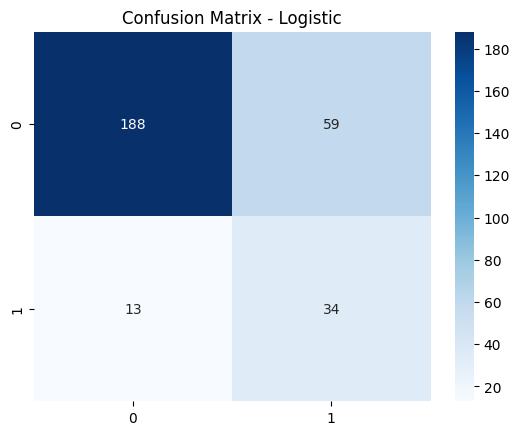

In [ ]:
# 12/ Matrice de confusion – Logistique

#Objectif : Évaluer les performances du modèle à l’aide d’une matrice de confusion.
# Pourquoi ? La matrice de confusion permet d’analyser les vrais positifs, faux positifs, vrais négatifs et faux négatifs.
# Résultat : On observe la capacité du modèle à détecter les employés quittant l’entreprise (classe 1).

cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic")
plt.show()

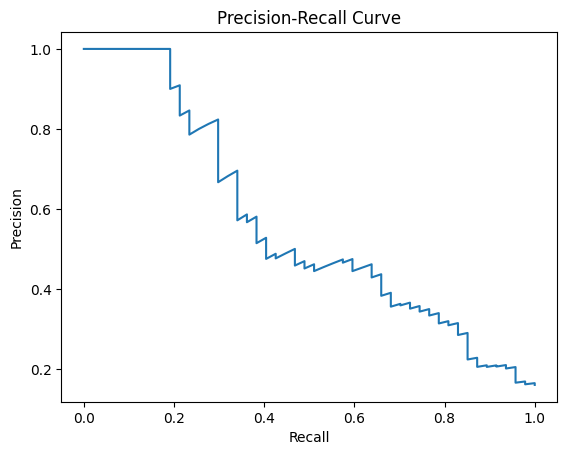

In [ ]:
# 13/ Courbe Precision–Recall

# Objectif : Visualiser le compromis entre précision et rappel.
# Pourquoi ? Dans un contexte déséquilibré, la courbe Precision–Recall est plus pertinente que l’accuracy.
# Résultat : La courbe montre comment évolue la performance selon le seuil de décision.

y_scores = log_model.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
# 14/ Modèle non linéaire — RandomForest + SMOTE

#Objectif : Entraîner un modèle plus puissant (Random Forest) avec gestion du déséquilibre via SMOTE.
#Pourquoi ?RandomForest capture des relations non linéaires.SMOTE permet de rééquilibrer les classes en générant artificiellement des exemples de la classe minoritaire.
#Résultat : Le modèle non linéaire est entraîné sur des données équilibrées.

rf_pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [ ]:

# 15/ Choix du seuil 

# Objectif : Définir un seuil personnalisé pour transformer les probabilités en prédictions.
# Pourquoi ? Le seuil par défaut (0.5) n’est pas toujours optimal en cas de déséquilibre.Un seuil plus bas peut améliorer le recall de la classe 1.
#Résultat : Les prédictions sont ajustées afin d’optimiser la détection des employés à risque.

y_prob_rf = rf_pipeline.predict_proba(X_test)[:,1]
threshold = 0.4
y_custom = (y_prob_rf > threshold).astype(int)

In [ ]:
# 16 / Stratification dans la validation croisée

# Objectif : Évaluer la stabilité du modèle via validation croisée stratifiée.
# Pourquoi ?  La stratification conserve la proportion des classes dans chaque fold. Cela permet d’obtenir une estimation robuste des performances.
# Résultat : On obtient une moyenne et un écart-type du recall, indiquant la stabilité du modèle.


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    rf_pipeline,
    X,
    y,
    cv=cv,
    scoring="recall"
)

print("Recall moyen :", scores.mean())
print("Écart-type :", scores.std())

Recall moyen : 0.299645390070922
Écart-type : 0.048883625042995725


In [ ]:
# 17/ Préparation pour interprétabilité

# Objectif : Encoder les variables catégorielles pour rendre les données compatibles avec SHAP.
# Pourquoi  ? SHAP nécessite des données numériques.  On utilise `pd.get_dummies()` pour transformer les variables catégorielles en variables binaires.
# Résultat : On obtient `X_encoded`, un dataset entièrement numérique prêt pour l’interprétation.

X_encoded = pd.get_dummies(X, drop_first=True)

In [ ]:
# 18/ Entraînement modèle dédié SHAP

# Objectif : Entraîner un modèle RandomForest dédié à l’interprétation.
# Pourquoi ? Le modèle utilisé dans un pipeline est plus complexe à interpréter directement avec SHAP.  On entraîne donc un modèle simple sur les données encodées.
# Résultat : Un modèle RandomForest est entraîné sur l’ensemble des données pour permettre une interprétation globale et locale.


rf_interpret = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

rf_interpret.fit(X_encoded, y)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# 19/ Création explainer SHAP

# Objectif : Créer un objet SHAP Explainer associé au modèle entraîné.
# Pourquoi ? L’explainer permet de calculer l’impact de chaque variable sur les prédictions du modèle.
# Résultat : Les valeurs SHAP peuvent maintenant être calculées pour analyser l’importance des variables.


explainer = shap.Explainer(rf_interpret)
shap_values = explainer(X_encoded)

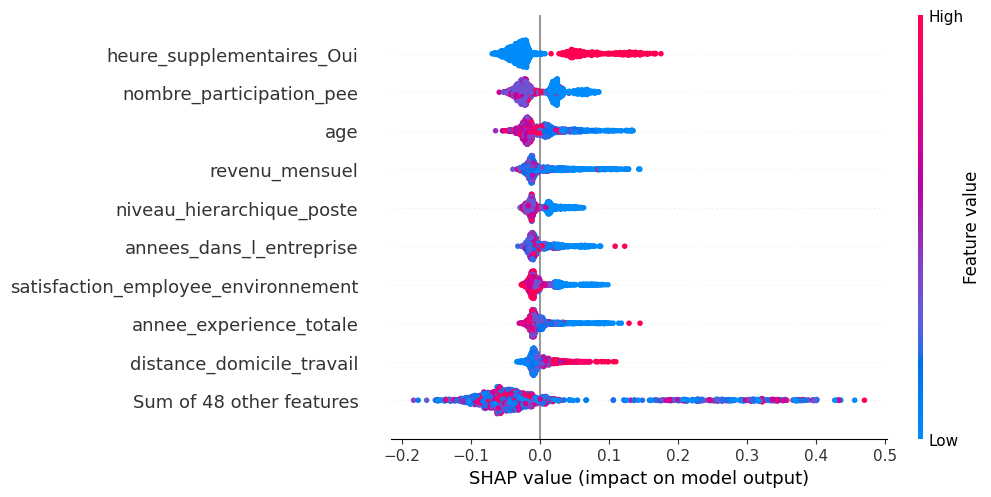

In [ ]:
# 20/ Summary plot global ( feature importance )

# Objectif : Visualiser l’importance globale des variables avec SHAP.
# Pourquoi ? Le summary plot montre quelles variables influencent le plus les prédictions, ainsi que le sens de leur impact (positif ou négatif).
# Résultat : On identifie les variables les plus déterminantes dans le turnover (impact moyen absolu des SHAP values).

shap.plots.beeswarm(shap_values[:,:,1])

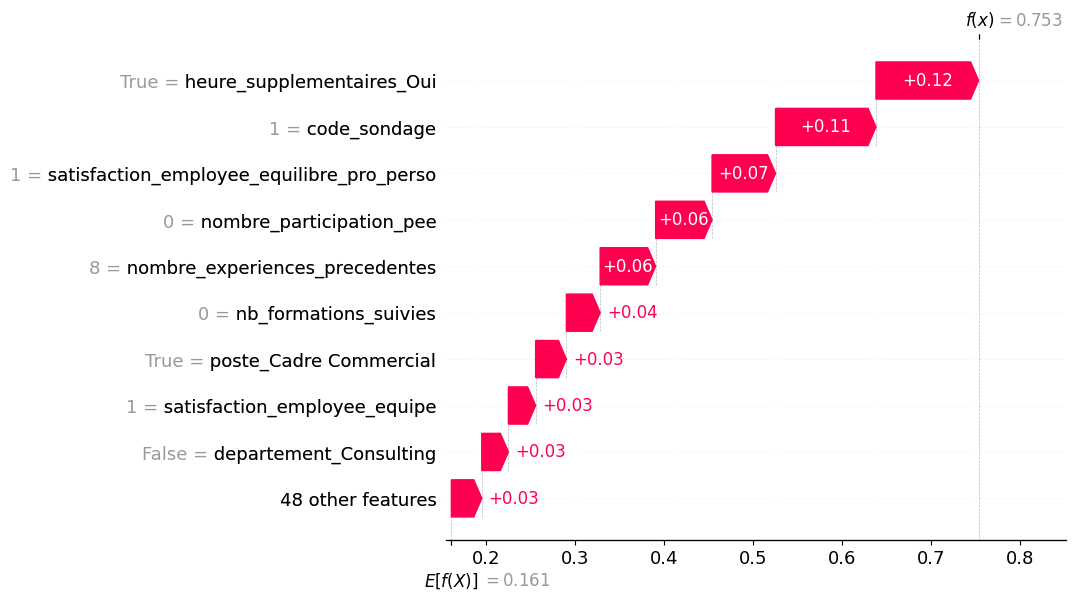

In [ ]:
# 21/ Individu analysé

# Objectif : Analyser en détail la prédiction pour un employé spécifique.
# Pourquoi ? Le waterfall plot montre comment chaque variable contribue à la probabilité finale de départ.
# Résultat : On comprend précisément pourquoi le modèle estime que cet employé a (ou non) un risque élevé de quitter l’entreprise.

shap.plots.waterfall(shap_values[0, :, 1])

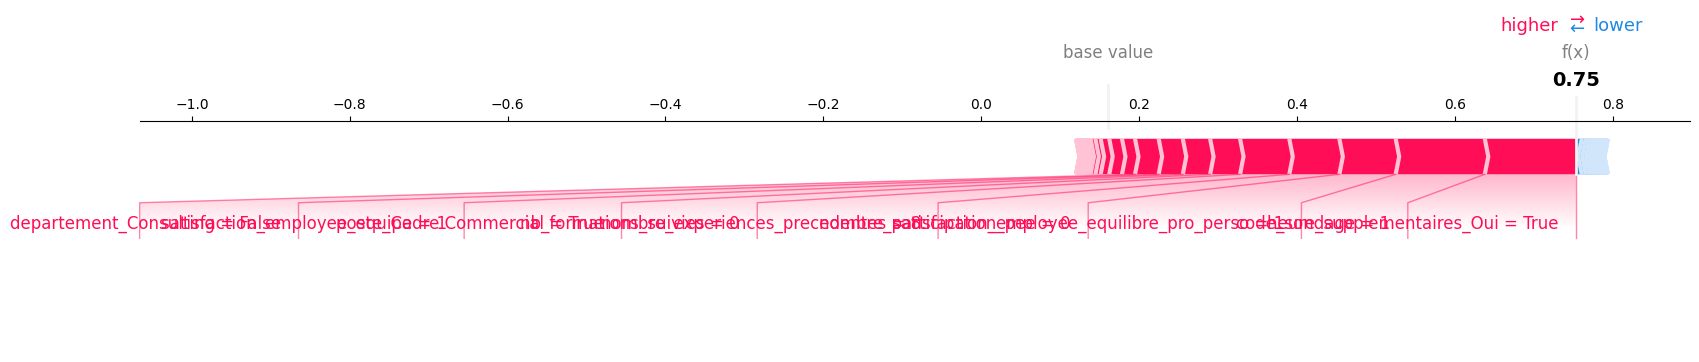

In [ ]:
# 22/ Force plot stable (matplotlib)

# Objectif : Visualiser de manière graphique et stable l’explication locale d’une prédiction.
# Pourquoi ? Le force plot montre les variables qui poussent la prédiction vers la classe 1 (départ) ou vers la classe 0 (rester).
# Résultat : On obtient une représentation claire des contributions positives et négatives à la décision du modèle.

shap.plots.force(shap_values[0, :, 1], matplotlib=True)

In [ ]:
# 23/ Validation croisée – moyenne & écart-type

# Objectif : Évaluer la robustesse du modèle via validation croisée.
# Pourquoi ? Cela permet de vérifier que les performances ne dépendent pas d’un seul découpage train/test.
# Résultat : On obtient une moyenne et un écart-type des métriques (ex : recall), indiquant la stabilité du modèle.

print("Validation croisée moyenne :", scores.mean())
print("Validation croisée std :", scores.std())

Validation croisée moyenne : 0.299645390070922
Validation croisée std : 0.048883625042995725
